In [1]:
import os
import scipy.io
import numpy as np
import scipy.linalg
import matplotlib.pyplot as plt

# Load training data from MAT file
R = scipy.io.loadmat('movie_data/movie_train.mat')['train']

# Load validation data from CSV
val_data = np.loadtxt('movie_data/movie_validate.txt', dtype=int, delimiter=',')

# Helper method to get training accuracy
def get_train_acc(R, user_vecs, movie_vecs):
    num_correct, total = 0, 0
    for i in range(R.shape[0]):
        for j in range(R.shape[1]):
            if not np.isnan(R[i, j]):
                total += 1
                if np.dot(user_vecs[i], movie_vecs[j])*R[i, j] > 0:
                    num_correct += 1
    return num_correct/total

# Helper method to get validation accuracy
def get_val_acc(val_data, user_vecs, movie_vecs):
    num_correct = 0
    for val_pt in val_data:
        user_vec = user_vecs[val_pt[0]-1]
        movie_vec = movie_vecs[val_pt[1]-1]
        est_rating = np.dot(user_vec, movie_vec)
        if est_rating*val_pt[2] > 0:
            num_correct += 1
    return num_correct/val_data.shape[0]

# Helper method to get indices of all rated movies for each user,
# and indices of all users who have rated that title for each movie
def get_rated_idxs(R):
    user_rated_idxs, movie_rated_idxs = [], []
    for i in range(R.shape[0]):
        user_rated_idxs.append(np.argwhere(~np.isnan(R[i, :])).reshape(-1))
    for j in range(R.shape[1]):
        movie_rated_idxs.append(np.argwhere(~np.isnan(R[:, j])).reshape(-1))
    return np.array(user_rated_idxs, dtype=object), np.array(movie_rated_idxs, dtype=object)

In [2]:
# Part (c): SVD to learn low-dimensional vector representations
def svd_lfm(R):

    # Fill in the missing values in R
    ##### TODO(c): Your Code Here #####
    R = np.nan_to_num(R)

    # Compute the SVD of R
    ##### TODO(c): Your Code Here #####
    U, d, V = scipy.linalg.svd(R, full_matrices = False)
    D = np.diag(d)
    
    # Construct user and movie representations
    ##### TODO(c): Your Code Here #####
    user_vecs = np.dot(U,D)
    movie_vecs = np.transpose(V)
    
    return user_vecs, movie_vecs

In [3]:
# Part (d): Compute the training MSE loss of a given vectorization
def get_train_mse(R, user_vecs, movie_vecs):
    # Compute the training MSE loss
    ##### TODO(d): Your Code Here #####
    mse_loss = 0
    for i in range(user_vecs.shape[0]):
        for j in range(movie_vecs.shape[0]):
            mse_loss += np.square((np.dot(user_vecs[i,:], movie_vecs[j,:]) - R[i,j]))
    return mse_loss

In [4]:
# Part (e): Compute training MSE and val acc of SVD LFM for various d
d_values = [2, 5, 10, 20]
train_mses, train_accs, val_accs = [], [], []
user_vecs, movie_vecs = svd_lfm(np.copy(R))

for d in d_values:
    train_mses.append(get_train_mse(np.copy(R), user_vecs[:, :d], movie_vecs[:, :d]))
    train_accs.append(get_train_acc(np.copy(R), user_vecs[:, :d], movie_vecs[:, :d]))
    val_accs.append(get_val_acc(val_data, user_vecs[:, :d], movie_vecs[:, :d]))
plt.clf()
plt.plot([str(d) for d in d_values], train_mses, 'o-')
plt.title('Train MSE of SVD-LFM with Varying Dimensionality')
plt.xlabel('d')
plt.ylabel('Train MSE')
plt.savefig(fname='train_mses.png', dpi=600, bbox_inches='tight')
plt.clf()
plt.plot([str(d) for d in d_values], train_accs, 'o-')
plt.plot([str(d) for d in d_values], val_accs, 'o-')
plt.title('Train/Val Accuracy of SVD-LFM with Varying Dimensionality')
plt.xlabel('d')
plt.ylabel('Train/Val Accuracy')
plt.legend(['Train Accuracy', 'Validation Accuracy'])
plt.savefig(fname='trval_accs.png', dpi=600, bbox_inches='tight')

KeyboardInterrupt: 

In [ ]:
# Part (f): Learn better user/movie vector representations by minimizing loss
# begin solution
best_d = 10

# end solution
np.random.seed(20)
user_vecs = np.random.random((R.shape[0], best_d))
movie_vecs = np.random.random((R.shape[1], best_d))
user_rated_idxs, movie_rated_idxs = get_rated_idxs(np.copy(R))

# Part (f): Function to update user vectors
def update_user_vecs(user_vecs, movie_vecs, R, user_rated_idxs):
    # Update user_vecs to the loss-minimizing value
    ##### TODO(f): Your Code Here #####
    x, y = user_vecs, movie_vecs
    yy = np.dot(y, y.T) + np.identity(y.shape[0]) #24x24
    temp = np.dot(np.linalg.inv(yy), R.T) #24 x 100
    user_vecs = np.dot(temp.T, y)
    
    return user_vecs

# Part (f): Function to update user vectors
def update_movie_vecs(user_vecs, movie_vecs, R, movie_rated_idxs):
    # Update movie_vecs to the loss-minimizing value
    ##### TODO(f): Your Code Here #####
    x, y = user_vecs, movie_vecs
    xx = np.dot(x, x.T) + np.identity(x.shape[0]) #24x24
    temp = np.dot(np.linalg.inv(xx), R) #24 x 100
    user_vecs = np.dot(temp, x)

    return movie_vecs

# Part (f): Perform loss optimization using alternating updates
train_mse = get_train_mse(np.copy(R), user_vecs, movie_vecs)
train_acc = get_train_acc(np.copy(R), user_vecs, movie_vecs)
val_acc = get_val_acc(val_data, user_vecs, movie_vecs)
print(f'Start optim, train MSE: {train_mse:.2f}, train accuracy: {train_acc:.4f}, val accuracy: {val_acc:.4f}')
for opt_iter in range(20):
    user_vecs = update_user_vecs(user_vecs, movie_vecs, np.copy(R), user_rated_idxs)
    movie_vecs = update_movie_vecs(user_vecs, movie_vecs, np.copy(R), movie_rated_idxs)
    train_mse = get_train_mse(np.copy(R), user_vecs, movie_vecs)
    train_acc = get_train_acc(np.copy(R), user_vecs, movie_vecs)
    val_acc = get_val_acc(val_data, user_vecs, movie_vecs)
    print(f'Iteration {opt_iter+1}, train MSE: {train_mse:.2f}, train accuracy: {train_acc:.4f}, val accuracy: {val_acc:.4f}')

Start optim, train MSE: nan, train accuracy: 0.5950, val accuracy: 0.5799


In [ ]:
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


def import_world_values_data():
    """
    Reads the world values data into data frames.

    Returns:
        values_train: world_values responses on the training set
        hdi_train: HDI (human development index) on the training set
        countries: countries corresponding to indices of values_train
    """
    values_train = pd.read_csv('world-values-train2.csv')
    countries = values_train['Country']
    values_train = values_train.drop(['Country'], axis=1)
    hdi_train = pd.read_csv('world-values-hdi-train2.csv')
    hdi_train = hdi_train.drop(['Country'], axis=1)
    return values_train, hdi_train, countries


def plot_pca(training_features,
             training_labels):
    """
    Input:
        training_features: world_values responses on the training set
        training_labels: HDI (human development index) on the training set
        training_classes: HDI class, determined by hdi_classification(), on the training set

    Output:
        Displays plot of first two PCA dimensions vs HDI
        Displays plot of first two PCA dimensions vs HDI, colored by class
    """
    # Run PCA on training_features
    ##### TODO(a): Your Code Here #####
    
    pca = PCA(n_components=2)
    pca.fit(training_features)
    transformed_features = pca.transform(training_features)
    
    # Plot countries by first two PCA dimensions
    plt.scatter(transformed_features[:, 0],     # Select first column
                transformed_features[:, 1],     # Select second column
                c=training_labels['2015'])
    plt.colorbar(label='Human Development Index')
    plt.title('Countries by World Values Responses after PCA')
    plt.show()


def hdi_classification(hdi):
    """
    Input:
        hdi: HDI (human development index) value

    Output:
        high HDI vs low HDI class identification
    """
    if 1.0 > hdi >= 0.7:
        return 1.0
    elif 0.7 > hdi >= 0.30:
        return 0.0
    else:
        raise ValueError('Invalid HDI')


In [2]:
"""
The world_values data set is available online at http://54.227.246.164/dataset/. In the data,
    residents of almost all countries were asked to rank their top 6 'priorities'. Specifically,
    they were asked "Which of these are most important for you and your family?"

This code and world-values.tex guides the student through the process of training several models
    that predict the HDI (Human Development Index) rating of a country from the responses of its
    citizens to the world values data.
"""

from math import sqrt
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import mean_squared_error, make_scorer

from world_values_utils import import_world_values_data
from world_values_utils import plot_pca

from world_values_pipelines import k_nearest_neighbors_regression_pipeline
from world_values_parameters import regression_knn_parameters


def main():
    print("Predicting HDI from World Values Survey\n")

    # Import Data #
    print("Importing Training Data")
    values_train, hdi_train, countries = import_world_values_data()

    # Center the HDI Values #
    hdi_scaler = StandardScaler(with_std=False)
    hdi_shifted_train = hdi_scaler.fit_transform(hdi_train)

    # Data Information #
    print('Training Data Count:', values_train.shape[0])

    # Part A: PCA (modify plot_pca method in world_values_utils) #
    plot_pca(values_train, hdi_train)

    # Part C: Find the 7 nearest neighbors of the U.S.
    nbrs = NearestNeighbors(n_neighbors=8).fit(values_train)
    us_features = values_train.iloc[45].to_numpy().reshape(1, -1)

    # Use nbrs to get the k nearest neighbors of us_features & retrieve the corresponding countries
    ##### TODO(c): Your Code Here #####
    
    distances, indices = nbrs.kneighbors(us_features)
    nn_indices = indices[0][1:]
    nn_countries = countries[nn_indices]
    print(nn_countries)

    # Part D: complete _rmse_grid_search to find the best value of k for Regression Grid Search #
    # Parts F and H: rerun this after modifications to find the best value of k for Regression Grid Search #
    _rmse_grid_search(values_train, hdi_shifted_train,
                      k_nearest_neighbors_regression_pipeline,
                      regression_knn_parameters, 'knn')


Predicting HDI from World Values Survey

Importing Training Data
Training Data Count: 148


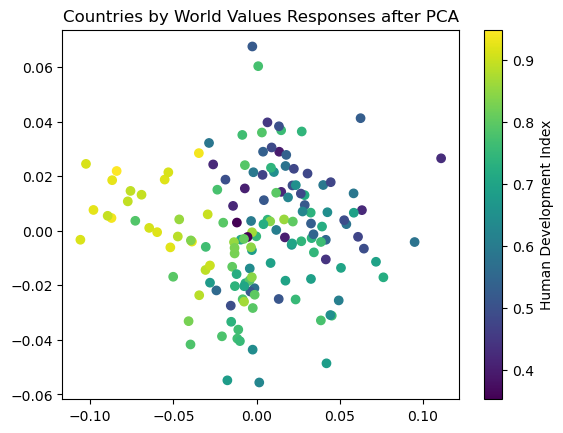

90            Ireland
61     United Kingdom
37            Belgium
108           Finland
69              Malta
132           Austria
110            France
Name: Country, dtype: object


/Users/AmandaRachelYao/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


RMSE: 0.11156444957797164
Pipeline(steps=[('scale', StandardScaler()),
                ('knn',
                 KNeighborsRegressor(n_neighbors=6, weights='distance'))]) 



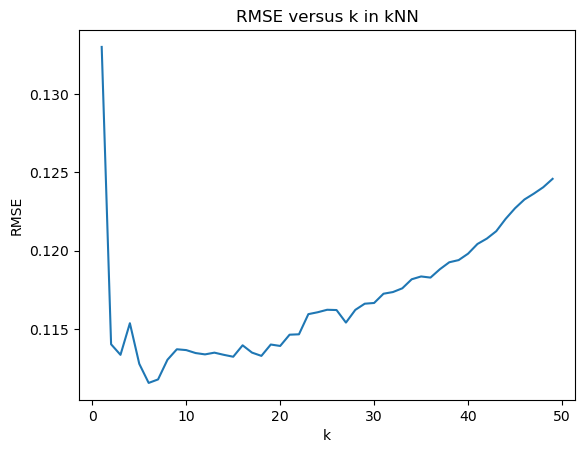

In [3]:
def _rmse_grid_search(training_features, training_labels, pipeline, parameters, technique):
    """
    Input:
        training_features: world_values responses on the training set
        training_labels: HDI (human development index) on the training set
        pipeline: regression model specific pipeline
        parameters: regression model specific parameters
        technique: regression model's name

    Output:
        Prints best RMSE and best estimator
        Prints feature weights for Ridge and Lasso Regression
        Plots RMSE vs k for k Nearest Neighbors Regression
    """
    # Use GridSearchCV to create and fit a grid of search results
    ##### TODO(d): Your Code Here #####
    #negated_RMSE = make_scorer(lambda label, pred: -np.sqrt(mean_squared_error(label, pred)))
    scoring = make_scorer(mean_squared_error, greater_is_better=False)
    grid = GridSearchCV(pipeline, parameters, scoring = scoring)
    #grid = GridSearchCV(pipeline, parameters, scoring = negated_RMSE)
    
    grid.fit(training_features, training_labels)
    print("RMSE:", sqrt(-grid.best_score_))
    print(grid.best_estimator_, "\n")
    
    # Plot RMSE vs k for k Nearest Neighbors Regression
    plt.plot(grid.cv_results_['param_knn__n_neighbors'],
             (-grid.cv_results_['mean_test_score'])**0.5)
    plt.xlabel('k')
    plt.ylabel('RMSE')
    plt.title('RMSE versus k in kNN')
    plt.show()

if __name__ == '__main__':
    main()